In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from flows import MaskingDense, IAF, MAF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
# 生成的z的维度。如果要训练，则考虑选择更大的dim
latent_dim = 32

learning_rate = 0.0005
dropout = 0.1

dataset_path = r"C:\Users\i9233\recommend system\dataset\hetrec2011-lastfm-2k"
hottest = int(math.pow(25, 2))

In [3]:
user_representation_normalized = pd.read_csv(dataset_path + "\\user_representation_sigmoid.csv" )
item_representation = pd.read_csv(dataset_path + "\\item_representation.csv" )

In [4]:
dataset_len = user_representation_normalized.shape[0]
target = np.zeros(dataset_len)

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((tf.cast(user_representation_normalized.values, 'float32'), target))

train_data = train_data.repeat().batch(batch_size).prefetch(1)

In [6]:
maf = MAF(original_size=hottest, latent_dim=latent_dim, num_flow=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# 训练maf
def train_maf(maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
            x_hat, _z_sigmas_2 = maf.generation(z_k)
            # 收敛非常快，暂时不知道原因
            loss = maf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)
            
        loss_list.append(loss)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
        gradients = g.gradient(loss, maf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))
    return loss_list

step: 0, loss: 403.125366
step: 2000, loss: 308.935913
step: 4000, loss: 307.064209
step: 6000, loss: 306.569763
step: 8000, loss: 306.126923
step: 10000, loss: 305.372864
step: 12000, loss: 305.302887
step: 14000, loss: 305.180145
step: 16000, loss: 305.147949
step: 18000, loss: 305.168213
step: 20000, loss: 305.137848


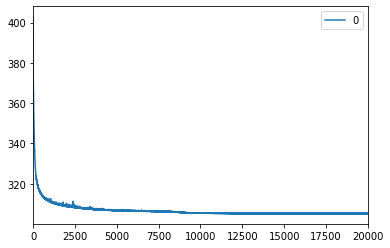

In [8]:
training_steps = 20000
display_step = 2000
loss_list = train_maf(maf, dataset=train_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [9]:
place = "./models/maf/lastfm_sigmoid_BinaryCrossentropy_%d_%d/" % (latent_dim, training_steps)
tf.saved_model.save(maf, place)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/maf/lastfm_sigmoid_BinaryCrossentropy_32_20000/assets


In [10]:
place = "./models/maf/lastfm_sigmoid_BinaryCrossentropy_%d_%d/" % (latent_dim, training_steps)
maf = tf.saved_model.load(place)

In [11]:
iaf = IAF(original_size=hottest, latent_dim=latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [12]:
def train_iaf_with_trained_maf(iaf, maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas2 = maf.inference(inputs)
            
            z_k_i, e_0, _z_log_sigma_0, _z_sigmas = iaf.inference(inputs)
            
            x_hat, _z_sigmas = iaf.generation(z_k_i) # 不计算会说有些没有训练到，故而注释掉
            
            iaf_loss = iaf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k_i)
            
            # CAF eq 20。最后一层的sigma，代表z自身的熵 
            H_z = tf.reduce_mean(np.log(2*math.pi * _z_sigmas[-1]))
            # CAF eq 21。maf和iaf生成的熵
            
            # 交叉熵最好先做归一化，如果不归一化，这里的z的预测会急剧变成全负数。目前考虑的是用sigmoid
            # 在正常训练中没有出现，是因为会保证其z约束在正态分布上。联合训练也会负，但是不快
            z_k = tf.math.sigmoid(z_k)
            z_k_i = tf.math.sigmoid(z_k_i)
            H_maf_iaf = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(z_k_i, z_k))
            
            loss =  H_z + H_maf_iaf + iaf_loss
            # 使用联合训练，iaf的loss下降很快，这里可以加入和直接iaf训练的对比图。因为求导的性质，也不需要担心对各个loss的减小的性能
            loss_list.append(iaf_loss)
        if step % display_step == 0:
            print("step: %i, H_z: %f, H_maf_iaf: %f, iaf_loss: %f" % (step, H_z, H_maf_iaf, iaf_loss))
        gradients = g.gradient(loss, iaf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))
    return loss_list

step: 0, H_z: 1.346887, H_maf_iaf: 0.812742, iaf_loss: 646.379578
step: 2000, H_z: 1.507389, H_maf_iaf: 0.802144, iaf_loss: 474.010895
step: 4000, H_z: 1.517445, H_maf_iaf: 0.805421, iaf_loss: 473.171906
step: 6000, H_z: 1.521120, H_maf_iaf: 0.808984, iaf_loss: 472.908905
step: 8000, H_z: 1.522843, H_maf_iaf: 0.804396, iaf_loss: 472.741608
step: 10000, H_z: 1.523695, H_maf_iaf: 0.804233, iaf_loss: 472.587372
step: 12000, H_z: 1.524178, H_maf_iaf: 0.802132, iaf_loss: 472.653076
step: 14000, H_z: 1.524396, H_maf_iaf: 0.807201, iaf_loss: 472.582642
step: 16000, H_z: 1.524493, H_maf_iaf: 0.806177, iaf_loss: 472.530426
step: 18000, H_z: 1.524549, H_maf_iaf: 0.808906, iaf_loss: 472.617676
step: 20000, H_z: 1.524583, H_maf_iaf: 0.810612, iaf_loss: 472.560852
step: 22000, H_z: 1.524597, H_maf_iaf: 0.805693, iaf_loss: 472.640411
step: 24000, H_z: 1.524606, H_maf_iaf: 0.800851, iaf_loss: 472.597534
step: 26000, H_z: 1.524610, H_maf_iaf: 0.802191, iaf_loss: 472.438660
step: 28000, H_z: 1.524613, 

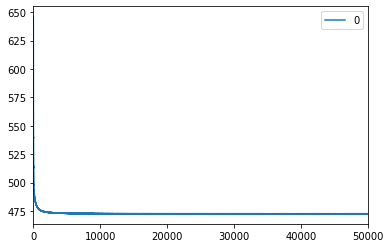

In [13]:
training_steps = 50000
display_step = 2000
loss_list = train_iaf_with_trained_maf(iaf, maf, dataset=train_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [14]:
place = "./models/iaf/lastfm_sigmoid_BinaryCrossentropy_%d_%d/" % (latent_dim, training_steps)
tf.saved_model.save(iaf, place)

INFO:tensorflow:Assets written to: ./models/iaf/lastfm_sigmoid_BinaryCrossentropy_32_50000/assets
